In [1]:
# Define ticket
ticket = 'JNJ'

# Use a new working directory for relative imports
from sys import path
import os

os.chdir(os.path.dirname(path[0]))
# print("New Working Directory " , os.getcwd())

In [2]:
from day_trading.files import DayTradingFiles
from day_trading.dataset import DayTradingDataset
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
from day_trading.model_generator import DayTradingModelGenerator
import pandas as pd
import os

# Prepare the models, targets, and features
files = DayTradingFiles()
dataset = DayTradingDataset()

(
    features_train_df, label_close_train,
    features_test_df, label_close_test
) = dataset.test_train_split(ticket, 'long')

print(f'Num true labels: {sum(label_close_train)}')

# Train the models
model_generator = DayTradingModelGenerator()
close_model = model_generator.get_best_model(features_train_df, label_close_train)
best_params = {
    'max_depth': 7,
    'min_samples_leaf': 10
}
# close_model = DecisionTreeClassifier(**best_params)
# close_model.fit(features_train_df, label_close_train)

print(features_test_df.head(10))

num_train_samples = features_train_df.shape[0]
num_test_samples = features_test_df.shape[0]
print(f'Training distribution: 0 ({(num_train_samples - sum(label_close_train))*100/num_train_samples:0.2f}%) - 1 ({sum(label_close_train)*100/num_train_samples:0.2f}%)')
print(f'Validation distribution: 0 ({(num_test_samples - sum(label_close_test))*100/num_test_samples:0.2f}%) - 1 ({sum(label_close_test)*100/num_test_samples:0.2f}%)')

Getting the data for the ticket
Getting data for JNJ
Convert the HTTP response into a pandas DataFrame
Processing data for JNJ
Processing data for JNJ
There are 6633 data points.
Defining the targets.
# Samples with NaN: 6633
# Samples without NaN: 6587
Two weeks ago: 2022-11-17 17:26:31.540703
Defining the training data.
Defining the test data.
Num true labels: 318
Best params: {'max_depth': 4, 'min_samples_leaf': 17}
           close   volume  day_of_week  hour  minute    EMA_20    EMA_50  \
5965  174.320007  19466.0            3    17      30 -0.315721 -0.502585   
5966  174.475006  27645.0            3    17      35 -0.425889 -0.631796   
5967  174.529999  26223.0            3    17      40 -0.435084 -0.659856   
5968  174.500000  28938.0            3    17      45 -0.366505 -0.605157   
5969  174.465897  51949.0            3    17      50 -0.300745 -0.548659   
5970  174.159500  36231.0            3    17      55  0.005114 -0.232762   
5971  174.360001  26222.0            3    18 

In [3]:
corr = features_test_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,close,volume,day_of_week,hour,minute,EMA_20,EMA_50,EMA_100,EMA_200,Support_pct_change,Resistance_pct_change,Delta_Close_Sum_0,Delta_Close_Sum_1,Delta_Close_Sum_2,RSI,MACD,MACD_Signal,p_Delta_High_1,p_Delta_Low_1,p_Delta_High_2,p_Delta_Low_2,p_Delta_High_3,p_Delta_Low_3,relative_volume,VWAP,ATR,ADX
close,1.000000,0.097325,-0.083524,-0.101535,0.020843,-0.335330,-0.428700,-0.428117,-0.354718,0.142990,0.118003,0.096827,0.031584,0.107555,0.096345,-0.407847,-0.411969,0.195715,-0.125262,0.100931,-0.102121,0.168045,-0.124099,0.097325,-0.137584,0.079544,-0.007002
volume,0.097325,1.000000,0.037547,-0.038688,0.151125,-0.181069,-0.154367,-0.120508,-0.076704,0.240533,-0.011206,0.029199,0.047365,0.004000,0.118544,-0.097310,-0.080723,0.251064,0.078792,0.029517,-0.029733,0.008262,-0.019405,1.000000,-0.063570,0.155751,-0.023143
day_of_week,-0.083524,0.037547,1.000000,-0.130217,0.011314,-0.237411,-0.365248,-0.409373,-0.376567,0.132760,0.028392,0.071868,0.074256,0.067050,0.046969,-0.350335,-0.372504,0.183596,-0.027105,0.179431,-0.025385,0.177918,-0.043363,0.037547,0.275381,0.189726,-0.060858
hour,-0.101535,-0.038688,-0.130217,1.000000,-0.114648,-0.115127,-0.055392,-0.006557,0.010593,-0.184327,0.301755,0.100070,0.155578,0.023877,0.201604,-0.062552,-0.019482,-0.174382,-0.286383,-0.101825,-0.282300,-0.159035,-0.168842,-0.038688,0.018123,-0.677472,0.006264
minute,0.020843,0.151125,0.011314,-0.114648,1.000000,-0.043433,-0.041612,-0.037412,-0.030847,0.039520,-0.038775,0.094964,-0.102270,0.137879,-0.019727,-0.030538,-0.022179,0.129020,-0.027450,-0.136642,-0.012310,0.127429,-0.063996,0.151125,0.005283,-0.013685,-0.019765
EMA_20,-0.335330,-0.181069,-0.237411,-0.115127,-0.043433,1.000000,0.909103,0.773578,0.615542,-0.523442,-0.440369,-0.616230,-0.281339,-0.241860,-0.801191,0.757432,0.565055,-0.658621,0.526564,-0.214077,0.286600,-0.209784,0.198258,-0.181069,-0.062376,-0.021198,0.063313
EMA_50,-0.428700,-0.154367,-0.365248,-0.055392,-0.041612,0.909103,1.000000,0.955493,0.827979,-0.423947,-0.326059,-0.469893,-0.323848,-0.323572,-0.634242,0.931386,0.840324,-0.555548,0.392333,-0.318902,0.307309,-0.322339,0.271390,-0.154367,-0.150555,-0.129250,0.039045
EMA_100,-0.428117,-0.120508,-0.409373,-0.006557,-0.037412,0.773578,0.955493,1.000000,0.948203,-0.331797,-0.260176,-0.365888,-0.287843,-0.314646,-0.505836,0.901488,0.873536,-0.444660,0.313303,-0.300161,0.276855,-0.326405,0.270808,-0.120508,-0.305424,-0.140591,0.007250
EMA_200,-0.354718,-0.076704,-0.376567,0.010593,-0.030847,0.615542,0.827979,0.948203,1.000000,-0.233447,-0.213901,-0.286596,-0.242495,-0.277171,-0.403857,0.771874,0.777387,-0.322220,0.269211,-0.229362,0.253692,-0.265037,0.259295,-0.076704,-0.530990,-0.072320,-0.032382
Support_pct_change,0.142990,0.240533,0.132760,-0.184327,0.039520,-0.523442,-0.423947,-0.331797,-0.233447,1.000000,0.201847,0.327427,0.035340,0.146252,0.413717,-0.282861,-0.180608,0.465292,-0.105958,0.086494,-0.009689,0.174073,-0.104204,0.240533,-0.042218,0.239054,-0.059399


"\n# Feature importance\nsorted_idx = np.argsort(close_model.coef_)[::-1][0]\nprint(f'Feature Importance:')\nfor index in sorted_idx:\n    print([features_train_df.columns[index], close_model.coef_[0][index]])\n\n\nsorted_idx = np.argsort(close_model.feature_importances_)[::-1]\nprint(f'Feature Importance:')\nfor index in sorted_idx:\n    print([features_test_df.columns[index], close_model.feature_importances_[index]])\n"

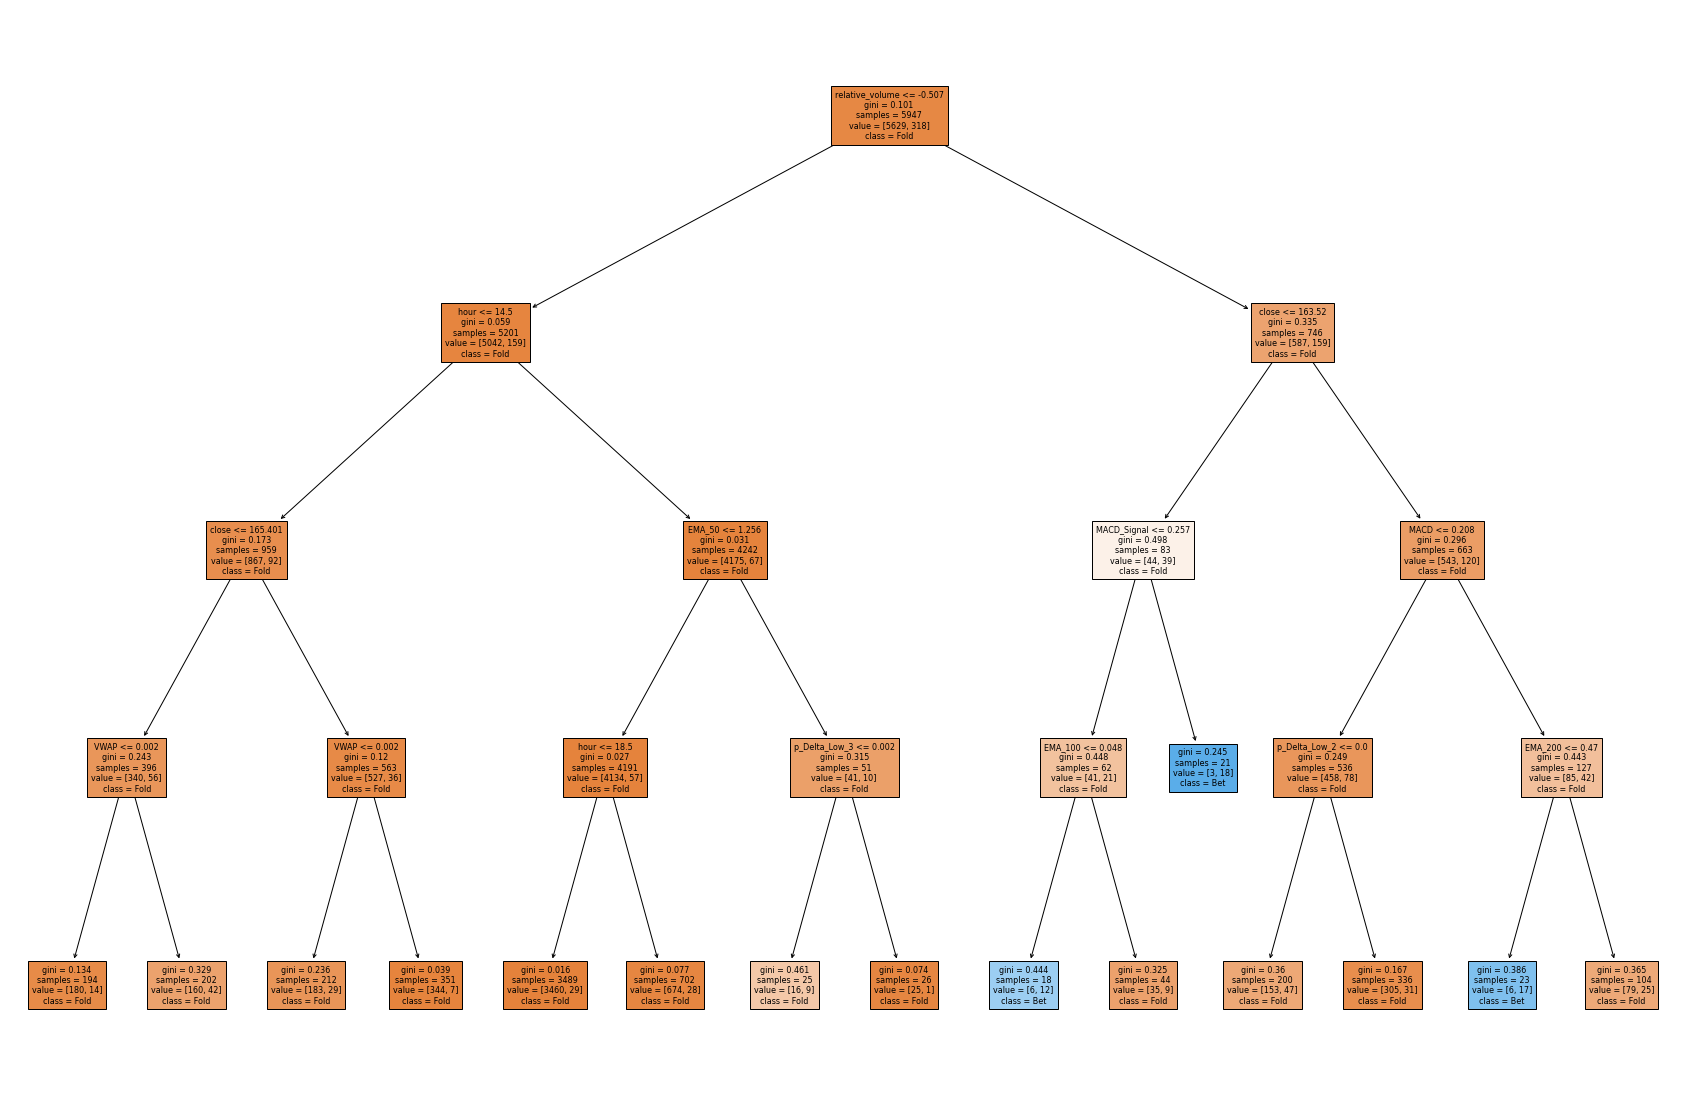

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(30,20))
_ = tree.plot_tree(close_model,
                   feature_names=features_train_df.columns,
                   class_names=["Fold", "Bet"],
                   filled=True,
                  fontsize=8)

"""
# Feature importance
sorted_idx = np.argsort(close_model.coef_)[::-1][0]
print(f'Feature Importance:')
for index in sorted_idx:
    print([features_train_df.columns[index], close_model.coef_[0][index]])


sorted_idx = np.argsort(close_model.feature_importances_)[::-1]
print(f'Feature Importance:')
for index in sorted_idx:
    print([features_test_df.columns[index], close_model.feature_importances_[index]])
"""

In [5]:
# Make predictions
close_predictions = close_model.predict(features_test_df)
prediction_score = close_model.predict_proba(features_test_df)[:, 1]

print(f'Sample Predictions: {close_predictions[:20]}')
print(f'Sample Probabilities: {prediction_score[:20]}')

Sample Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample Probabilities: [0.00831184 0.00831184 0.00831184 0.00831184 0.00831184 0.00831184
 0.00831184 0.00831184 0.00831184 0.00831184 0.00831184 0.00831184
 0.00831184 0.00831184 0.00831184 0.00831184 0.00831184 0.00831184
 0.03988604 0.03988604]


Precision: 0.0
Recall: 0.0
Accuracy: 0.9640625
F1-Score: 0.0
Confusion Matrix:
 [[617   0]
 [ 23   0]]


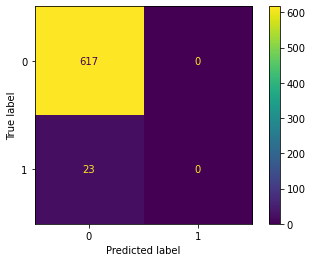

In [6]:
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    confusion_matrix, f1_score, ConfusionMatrixDisplay
)

print(f'Precision: {precision_score(label_close_test, close_predictions)}')
print(f'Recall: {recall_score(label_close_test, close_predictions)}')
print(f'Accuracy: {accuracy_score(label_close_test, close_predictions)}')
print(f'F1-Score: {f1_score(label_close_test, close_predictions)}')
print(f'Confusion Matrix:\n {confusion_matrix(label_close_test, close_predictions)}')
cm_display = ConfusionMatrixDisplay(confusion_matrix(label_close_test, close_predictions)).plot()

In [7]:
features_test_df['true_label'] = label_close_test
features_test_df['prediction'] = close_predictions
features_test_df['probability_score'] = prediction_score

In [8]:
features_test_df.to_csv(files.features_sample, index=False)
false_negatives = features_test_df.query('true_label == 1 and prediction == 0').copy()
false_negatives.to_csv(files.false_negatives, index=False)
false_positives = features_test_df.query('true_label == 0 and prediction == 1').copy()
false_positives.to_csv(files.false_positives, index=False)
true_positives = features_test_df.query('true_label == 1 and prediction == 1').copy()
true_positives.to_csv(files.true_positives, index=False)